<a href="https://colab.research.google.com/github/anochima/helpers/blob/master/Cosmo_Face_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#### Clone Git repo of function libraries



In [ ]:
! git clone https://github.com/anochima/helpers.git

#### Make neccessary installations

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as pimg 
import tensorflow as tf
import pandas as pd
import numpy as np
import random 
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Problem Definition
We are trying to distinguish between images that are real from images that are fake. This will enable me or any firm planning to integrate this fish out fake image upload from users on their platform.

In order to achieve this we have downloaded a dataset of faces from [kaggle.com/ciplab/real-and-fake-face-detection](https://) which is categorized into fake and real classes

# Steps we will take to get this project done are:


1.   Get the image data
2.   Visualize and get to understand what our data looks like
3. Prepare our data for our neural network
4. Build a CNN base model for prediction
5. Evaluate and Improve our model
6. Are we satisfied? if not, REPEAT 😅

# Deployment 

After building this model it will be deployed to google GCP (Google Cloud Platform) where it will be rendered as an API


# Get the image data

In [4]:
path = '/content/drive/MyDrive/real_and_fake_face/'
image_classes = os.listdir(path)

In [5]:
# Lets checkout how many paths are there in our image_path
image_classes

['not_face', 'face']

In [6]:
# Our image path contains an extra class '.ipynb_checkpoints', so let's see if we can take it out
! rm -rf .ipynb_checkpoints*
image_classes

['not_face', 'face']

In [7]:
# Check the amount of data we are trying to work with
for dir in os.listdir(path):
  print(f'There are at least {len(os.listdir(os.path.join(path, dir)))} {dir} images to work with.')

There are at least 960 not_face images to work with.
There are at least 1078 face images to work with.


# Visualize our Images 
So far we've gotten our image data, therefore in order to get a better understanding of what they look like, let's visualize them.

We will create a helper function to help us visualize what these images look like. Let's code.

In [8]:
def show_image(path='/content/drive/MyDrive/real_and_fake_face/', class_name=''):
  if class_name == '':
    print('Please pass a class name')
  else:
    try:
      img_path = os.listdir(os.path.join(path, class_name))
      selected_img = random.choice(img_path)
      image = plt.imread(os.path.join(path, class_name, selected_img))
      
      # Let's plot the image
      plt.figure(figsize=(15, 5))
      plt.imshow(image)
      plt.axis('off')
      plt.title(f'File Name: {selected_img} \n Class Name: {class_name} \n Shape: {image.shape}')
      
    except FileNotFoundError:
      print(f'Sorry no such class name "{str(class_name).capitalize()}" was found in path {path}')

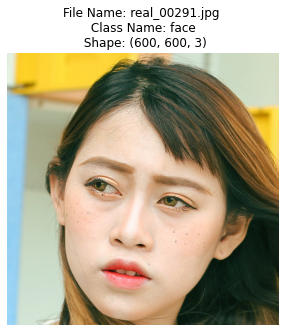

In [9]:
# Let's Checkout some real images
show_image(class_name='face')

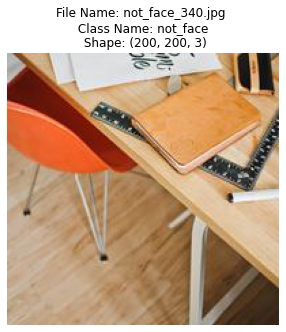

In [10]:
# Let's checkout some fake image
show_image(class_name='not_face')

# Prepare our data for our neural network

We've visualized a fair few amount of images, now lets prepare our data, to feed to a neural network

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
BATCH_SIZE = 16
IMG_HEIGHT = 124
IMG_WIDTH = 124
PATH = '/content/drive/MyDrive/real_and_fake_face/'

# Instantiate ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.2)

# scale the images
train_data = image_gen.flow_from_directory(directory=PATH,
                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                           class_mode='binary',
                                           subset='training',
                                           batch_size=BATCH_SIZE,
                                           seed=42,
                                           shuffle=True)

test_data = image_gen.flow_from_directory(directory=PATH,
                                          target_size=(IMG_HEIGHT,IMG_WIDTH),
                                          class_mode='binary',
                                          subset='validation',
                                          batch_size=BATCH_SIZE,
                                          seed=42,
                                          shuffle=True)

Found 1630 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


In [13]:
train_data.class_indices

{'face': 0, 'not_face': 1}

# Build a CNN base model for prediction
Now let's build a model to try predict what class an image falls into, let's do this!!

We took a few look at what our processed image data looks like and we found out the image not yet normalized. Remember that neural network best perform well on normalized data. So we need to normalize the data before feeding it to our neural network

In [14]:
# Build our model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Conv2D(16, 2, activation='relu'),
    tf.keras.layers.MaxPool2D(), 
    tf.keras.layers.Conv2D(32, 2, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64,2, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [15]:
# Compile our model
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [16]:
# Fit the data to our model
history_1 = model.fit(train_data, 
                      epochs=5, 
                      validation_data=test_data, 
                      validation_steps=len(test_data), 
                      steps_per_epoch=len(train_data))

Epoch 1/5
102/102 [==============================] - 459s 4s/step - loss: 0.3050 - accuracy: 0.8577 - val_loss: 0.1138 - val_accuracy: 0.9607
Epoch 2/5
102/102 [==============================] - 17s 166ms/step - loss: 0.1274 - accuracy: 0.9571 - val_loss: 0.0890 - val_accuracy: 0.9754
Epoch 3/5
102/102 [==============================] - 17s 168ms/step - loss: 0.0970 - accuracy: 0.9632 - val_loss: 0.1822 - val_accuracy: 0.9361
Epoch 4/5
102/102 [==============================] - 17s 168ms/step - loss: 0.1009 - accuracy: 0.9595 - val_loss: 0.1030 - val_accuracy: 0.9631
Epoch 5/5
102/102 [==============================] - 18s 172ms/step - loss: 0.0708 - accuracy: 0.9761 - val_loss: 0.0916 - val_accuracy: 0.9656


# Plot a history graph to visualize how our model is learning

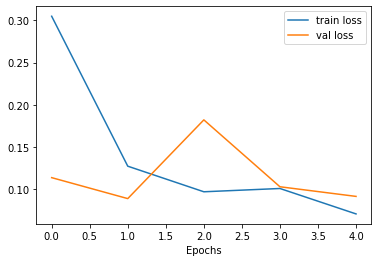

In [19]:
def plot_history(history):
  """
  Returns a plots of model learning history object

  Args:
    history: Model's learning history object
  
  Returns:
    A plot of of model learning history
  """

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  # Plot the histories

  plt.plot(train_loss)
  plt.plot(val_loss)
  plt.xlabel('Epochs')
  plt.legend(['train loss','val loss']);

plot_history(history_1)

In [ ]:
# Create a function to enable us check our model performance on unseen data
def decode_image(image_path):
  image = tf.io.read_file(image_path)
  decoded_image = tf.io.decode_image(image)
  
  # Resize the image
  image = tf.image.resize(decoded_image, size=[IMG_HEIGHT, IMG_WIDTH])
  
  # Normalize the image
  image = image/255.
  
  # Predict
  prediction = model.predict(tf.expand_dims(image, axis=0))
  print(prediction)
  print(int(tf.round(prediction)))
  prediction = image_classes[int(tf.round(prediction))]
  
  # plot
  plt.figure(figsize=(12, 8))
  plt.imshow(decoded_image)
  plt.title(prediction)
  plt.axis('off')

[[0.9712809]]
1


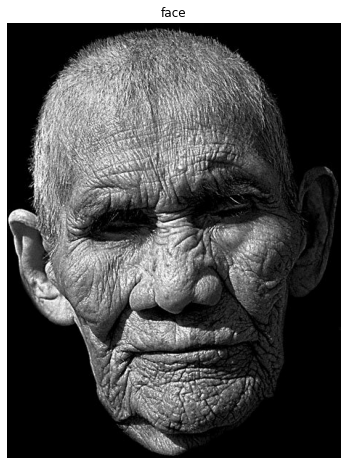

In [ ]:
decode_image('/content/drive/MyDrive/Human-faces/Humans/1 (1000).jpg')

[[0.99701035]]
1


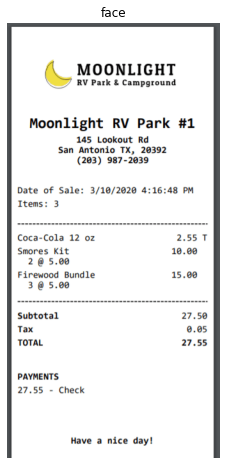

In [ ]:
decode_image('/content/drive/MyDrive/temp_ocr_receipts/moonlight.png')

In [ ]:
image, class_names = train_data.next()
class_names

array([0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.],
      dtype=float32)